# Principles of Data Assimilation with easy-to-follow Python module implementation: A case study with the Lorenz 63 model 

## Introduction

Data assimilation is used to optimally combine a surrogate model withs parse noisy data ie combine different sources of information to estimate possible states of a system as it evolves in time. Then, data assimilation offers a suite of algorithms that merge measurement data with numerical simulations to predict accurate state trajectories.

In this notebook, we are going to explain what data assimilation is and explore one of DA techniques: sequential DA using the ensemble Kalman Filter. The lorenz 96 model is a special case study we'll use to implement our algorithm and plots the results.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Preliminaries

### Notations

In general, we assume that all vector-valued functions or variables are written as a column vector. Unless stated otherwise, boldfaced lowercase letters are used to denote vectors and boldface uppercase letters are reserved to matrices.
 
At any time t, let's denote our system state $\mathbf{u}(t) = [u_1(t), \dots, u_n(t)]^T \in \mathbb{R}^n$. The dynamics of the system are governed by the following differential equation:

\begin{equation*}
    \frac{d \mathbf{u}}{dt} = \mathbf{f}(\mathbf{u}, \mathbf{\theta})
    \label{eq:sys_dynamics}
    \tag{1}
\end{equation*}

where $\mathbf{f}: \mathbb{R}^n \times \mathbb{R}^p \rightarrow \mathbb{R}^n$ encapsulates the model’s dynamics, with $ \theta \in \mathbb{R}^p $ being the vector of model’s parameters.  With a time-integration scheme applied, the discrete-time model can be written as follows:

\begin{equation*}
    \mathbf{u}_{k+1}(t) = \mathbf{M}(\mathbf{u}_k(t), \theta)
    \label{eq:sys_dynamics_discrete}
    \tag{2}
\end{equation*}

where $\mathbf{M}$ is the one-time step transition map that evolves the state at time $t_k$ to time $t_{k+1}=t_k + \Delta t$, with $\Delta t$ being the time step length.

Let's introduce $\mathbf{u}_b$ the background knowledge (our prior information), $\mathbf{u}_t$ the true value of the state variable and $\xi_b = \mathbf{u}_y - \mathbf{u}_b$ the noise between the true state and the background information.
From probabilistic point of view, we assume $\xi_b = \mathcal{N}(0, \mathbf{B}) $ where $\mathbf{B}$ is the covariance matrix.

We define the set of the collected measurements at a specific time $t_k$ as $\mathbf{w}(t_k) \in \mathbb{R}^m$ which is linked to the state vector by:
\begin{equation*}
    \mathbf{w}(t_k) = \mathbf{h}(\mathbf{u(t_k)}) + \xi_m
    \label{eq:state_obs}
    \tag{3}
\end{equation*}

or 

\begin{equation*}
    \mathbf{w}(t_k) = \mathbf{H} \mathbf{u}_k(t) + \xi_m
    \label{eq:state_obs_discrete}
    \tag{4}
\end{equation*}

where $\mathbf{h}: \mathbb{R}^n \rightarrow \mathbb{R}^m$ defines the mapping from state-space to measurement-space and $\xi_m \in \mathbb{R}^m$ denotes the measurement noise. $\xi_m$ is assumed to possess a multivariate normal distribution, with a zero mean and a covariance matrix $\mathbf{R}$ ($\xi_m = \mathcal{N}(0, \mathbf{R})$).

An extra grounding assumption is that the measurement noise and thestate variables (either true or background) are uncorrelated. Furthermore, all noises are assumed to be temporally uncorrelated (i.e., white noise).


**Data Assimilation objective**: 

Provide an algorithm that fuses our prior information $\mathbf{u}_b$ and measurement data $\mathbf{w}$ to yield a better approximation of the unknown true state.  This better approximation  is  called  the  analysis,  and  denoted  as $\mathbf{u}_a$. The  difference  between  this  better approximation and the true state is denoted as $\xi_a = \mathbf{u}_t - \mathbf{u}_a$.

### Twin experiment

In a realistic situation, the true state values are unknown and noisy measurements are collected bysensing devices. However, for testing ideas, the ground truth need to be known beforehand such thatthe convergence and accuracy of the developed algorithm can be evaluated. In this sense, the conceptof twin experiment has been popular in data assimilation (and inverse problems, in general) studies.

Twin data assimilation experiments are a common approach to assess data assimilation methods. In twin experiments one uses the model to generate a true model state. Further one generates synthetic observations by adding random perturbations to the true state. The, in the actual twin experiment one starts the data assimilation with a state estimate that is different from the true state and assimilates the synthetic observations. One can analyze the assimilation result by comparing the state estimate from the twin experiment with the previously generated true state. 

## Lorenz 63 system

 In 1963, Edward Lorenz, with the help of Ellen Fetter, developed a simplified mathematical model for atmospheric convection. The model is a system of three ordinary differential equations now known as the Lorenz equations:
 
\begin{equation*}
    \begin{cases}
        \frac{dx}{dt} &= \sigma(y -x) \\
        \frac{dy}{dt} &= x(\rho - z) - y \\
        \frac{dz}{dt} &= xy - \beta z 
    \end{cases}
    \label{eq:lorenz_63}
    \tag{5}
\end{equation*}
 
The equations relate the properties of a two-dimensional fluid layer uniformly warmed from below and cooled from above. In particular, the equations describe the rate of change of three quantities with respect to time: $x$ is proportional to the rate of convection, $y$ to the horizontal temperature variation, and $z$ to the vertical temperature variation. The constants $\sigma$ , $\rho$, and $\beta$ are system parameters proportional to the `Prandtl number`, `Rayleigh number`, and certain physical dimensions of the layer itself.

The values of $\sigma = 10$, $\beta = \frac{8}{4}$, $\rho = 28$ are usually used to exhibit a chaotic behavior. If we like to put Equation $\eqref{eq:lorenz_63}$ with the notations introduced in **Preliminaries**, we can write $ \mathbf{u} = [x, y, z]^T$ with $n=3$, and $ \theta = [\sigma, \beta, \rho]^T$ with $p=3$. A Python function describing the dynamics of the Lorenz 63 system is given below

In [2]:
def Lorenz63(state, *args): # Lorenz 63 model
    sigma, beta, rho = args
    x, y, z = state # Unpack the state vector
    f = np.zeros(3) # Derivatives
    f[0] = sigma*(y - x)
    f[1] = x*(rho - z) - y
    f[2] = x*y - beta*z
    return f

## Temporal integration schemes

Equation $\eqref{eq:lorenz_63}$ describe the continuous-time evolution of the Lorenz system. In order to obtain the discrete-time mapping $\mathbf{M}$, a temporal integration scheme has to be applied. 
We can use the first-order **Euler** and the fourth-order **Runge–KuKutta** schemes.

In [3]:
# rhs:  right-hand side function, this is mainly the continuous-time model f(u)
# state: current state of the system
# dt: time step
# args: other parmaters (here it is theta = (sigma, beta, rho) of the lorenz 63 system)

def euler(rhs, state, dt, *args):
    k1 = rhs(state, *args)
    new_state = state + dt*k1
    return new_state


def RK4(rhs, state, dt, *args):
    k1 = rhs(state, *args)
    k2 = rhs(state+k1*dt/2, *args)
    k3 = rhs(state+k2*dt/2, *args)
    k4 = rhs(state+k3*dt, *args)
    new_state = state + (dt/6)*(k1+2*k2+2*k3+k4)
    return new_state

## Twin experiment testing

For  twin  experiment  testing,  we  suppose  a  true  initial  condition  of $\mathbf{u}_t(0) = [1, 1, 1]^T$ and measurements are collected each $0.2$ time units for a total time of $2$.  We suppose that we measure the full system state (i.e., $h(\mathbf{u}) = \mathbf{u}$, $m = 3$,  and $\mathbf{H} = \mathbf{I}_3$,  where $\mathbf{I}_3$ is the $3×3$ identity matrix). Measurements are considered to be contaminated by a white Gaussian noise with a zero mean and a covariance matrix $\mathbf{R} =Diag(\sigma_1^2, \sigma_2^2, \sigma_3^2)$.  For simplicity, we let $ \sigma_1^2 = \sigma_2^2 = \sigma_3^2 = 0.15$.

In [4]:
# system parameters
sigma = 10.0
beta  = 8.0/3.0
rho   = 28.0

# time axis
dt = 0.01
tm = 10
nt = int(tm/dt)
t  = np.linspace(0, tm, nt+1)

In [5]:
def h(u):  # Observation operator
    w = u
    return w

def Dh(u): # Jacobian of observation operator
    n = len(u)
    D = np.eye(n)
    return D

np.random.seed(seed=1)            # set seed

u0True = np.array([1, 1, 1])      # True initial conditions
sig_m  = 0.15                     # standard deviation for measurement noise
R      = sig_m**2 * np.eye(3)     # covariance matrix for measurement noise
dt_m   = 0.2                      # time period between observations
tm_m   = 2                        # maximum time for observations
nt_m   = int(tm_m/dt_m)           # number of observation instants
ind_m  = (np.linspace(int(dt_m/dt), int(tm_m/dt), nt_m)).astype(int)
t_m    = t[ind_m]                 # time integration

uTrue  = np.zeros([3, nt+1])
uTrue[:, 0] = u0True
km = 0
w  = np.zeros([3, nt_m])
for k in range(nt):
    uTrue[:, k+1] = RK4(Lorenz63, uTrue[:, k], dt, sigma, beta, rho)
    if (km < nt_m) and (k+1 == ind_m[km]):
        w[:, km] = h(uTrue[:, k+1]) + np.random.normal(0, sig_m, [3,])
        km += 1

In [10]:
t_m

array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ])

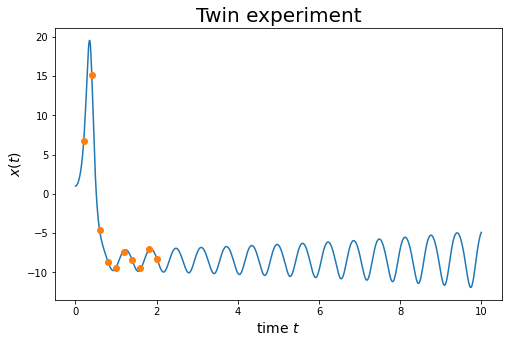

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(t, uTrue[0, :])
ax.plot(t_m, w[0, :], 'o')
ax.set_xlabel("time $t$", fontsize=14)
ax.set_ylabel("$x(t)$", fontsize=14)

plt.title('Twin experiment', fontsize=20)
# plt.savefig("twin_exp")
plt.show()

## Kalman Filtering

The idea behind Kalman filtering techniques is to propagate the mean as well as the covariance matrix of the system’s state sequentially in time. That is, in addition to providing an improved state estimate (i.e., the analysis), it also gives some information about the statistical properties of this state estimate. This is one main difference between Kalman filtering and variational methods, which often assumes a fixed (stationary) background covariance matrices.

Although most application in fluid dynamics involve nonlinear systems, we first describe thestandard Kalman filter developed for the linear dynamical system case with linear observation operatordescribed as:


\begin{equation*}
    \mathbf{u_t}(t_{k+1}) = \mathbf{M_k} \mathbf{u}_t(t_k) + \xi_p(t_k)
    \label{eq:sys_dynamics_discrete_kf}
    \tag{6}
\end{equation*}


\begin{equation*}
    \mathbf{w}(t_k) = \mathbf{H_k} \mathbf{u}_t(t_k) + \xi_m(t_k)
    \label{eq:state_obs_discrete_kf}
    \tag{7}
\end{equation*}

where $\xi_p \in \mathbb{R}^n$ is the process noise (or model error).

Since $\xi_b = \mathcal{N}(0, \mathbf{B})$, the true state $\mathbf{u}_t(t_k)$ is assumed to be a random variable with known mean $E[\mathbf{u}_t(t_k)] = \mathbf{u}_b(t_k)$ and  covariance  matrix  of $E[(\mathbf{u}_t(t_k) - \mathbf{u}_b(t_k))(\mathbf{u}_t(t_k) - \mathbf{u}_b(t_k))^T] = \mathbf{B}_k$.In Kalman filtering, we note that the covariance matrix evolves in time, and thus appears the subscript. We also assume that the process noise is unbiased with zero mean and a covariance matrix Q. That is $E(\xi_p(t_k)) = 0$ and $E(\xi_p(t_k)\xi_p(t_k)^T) = \mathbf{Q}_k$.

Thus, the goal of the filtering problem is to find a good estimate (analysis) $\mathbf{u}_a(t_k)$ of the true system’s state $\mathbf{u}_t(t_k)$ given a dynamical model a set of noisy observation $\{\mathbf{w}(t_i)\}$ collected at sometime instants $t_i \in (0, t_k]$. The optimality of the estimate $\mathbf{u}_a(t_k)$ is defined as the one which minimizes $E[(\mathbf{u}_t(t_k) - \mathbf{u}_a(t_k))(\mathbf{u}_t(t_k) - \mathbf{u}_a(t_k))^T]$. This filtering process generally consists of two steps: the **forecast step** and the **data assimilation step**.

The forecast step is performed using the predictable part of the given dynamical model starting from the best known information at time $t_k$ (denoted as $\hat{\mathbf{u}}_b(t_k)$) to produce a forecast or backgrounde stimate $\mathbf{u}_b(t_{k+1}) = \mathbf{M}_k \hat{\mathbf{u}}_b(t_k)$. The difference between the background forecast and true state at $t_{k+1}$ can be written as follows:

* Continue the description here.....

For data assimilation testing, we assume that we begin with a perturbed initial condition of $\mathbf{u}(0) = [2, 3, 4]^T$.Then, background state values are computed at $t=0.2$ by time integration of Equation(5) starting from this false initial condition.  Observations at $t=0.2$ are assimilated to provide the analysis at $t=0.2$. After that, background state values are computed at $t=0.4$ by time integration of Equation (5) starting from the analysis at $t=0.2$, and so on. Solution trajectories are presented for a total time of $10$, where observations are only available up to $t=2$.

## Application to our Lagrandian model 